# Convolutional Neural Networks

intro stuff

In [1]:
import sys
sys.path.append('../')

from util_files.common_imports import *
from util_files.common_mars_function import *

# Prepare the data

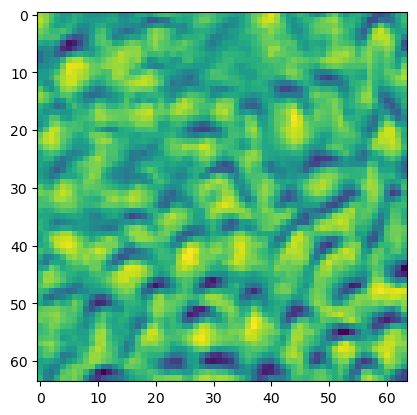

Shape of training images: (588, 64, 64)
Shape of testing images: (253, 64, 64)


In [2]:
dir_path = 'data/tiled_img_brain_terrain_64'
images, filenames = load_images_from_directory(dir_path)
plt.imshow(images[0])
plt.show()

# Preprocess the data (reshaping, normalization)
images_resized = [resize_image(img, (64, 64)) for img in images]
images_normalized = [(img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img)) for img in images_resized]
images = np.array(images_normalized)

# split into train/test subsets
train_images, test_images,= train_test_split(
    images, test_size=0.3, random_state=42
)
print(f"Shape of training images: {train_images.shape}")
print(f"Shape of testing images: {test_images.shape}")

# Prepare a network

## Basic building blocks
### Explanation of Key Concepts

#### Convolutional Block (`conv_block`)

- Applies two convolutional layers with a kernel size of 3 and padding set to 'same' to preserve the spatial dimensions.
- Each convolutional layer is followed by a ReLU activation function to introduce non-linearity.

#### Encoder Block (`encoder_block`)

- Applies a convolutional block to the input tensor.
- Follows the convolutional block with a max pooling layer to reduce the spatial dimensions by a factor of 2.
- Returns the output of the convolutional block and the pooled tensor.

#### Decoder Block (`decoder_block`)

- Applies a transposed convolutional layer (also known as a deconvolutional layer) to upsample the input tensor.
- Concatenates the upsampled tensor with a skip connection tensor from the encoder block.
- Applies a convolutional block to the concatenated tensor.
- Returns the output tensor after the convolutional block.

In [3]:
def conv_block(input_tensor, num_filters):
    """
    A convolutional block that applies two convolutional layers followed by ReLU activation.

    Parameters:
    input_tensor (tensor): Input tensor to the convolutional block.
    num_filters (int): Number of filters for the convolutional layers.

    Returns:
    tensor: Output tensor after applying two convolutional layers and ReLU activation.
    """
    # First convolutional layer with ReLU activation
    x = Conv2D(num_filters, kernel_size=3, padding='same')(input_tensor)
    x = ReLU()(x)
    
    # Second convolutional layer with ReLU activation
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = ReLU()(x)
    
    return x

def encoder_block(input_tensor, num_filters):
    """
    An encoder block that applies a convolutional block followed by max pooling.

    Parameters:
    input_tensor (tensor): Input tensor to the encoder block.
    num_filters (int): Number of filters for the convolutional layers.

    Returns:
    tuple: Output tensor after the convolutional block and the pooled tensor.
    """
    # Apply the convolutional block
    x = conv_block(input_tensor, num_filters)
    
    # Apply max pooling to reduce the spatial dimensions
    p = MaxPooling2D(pool_size=(2, 2))(x)
    
    return x, p

def decoder_block(input_tensor, skip_tensor, num_filters):
    """
    A decoder block that applies a transposed convolutional layer, concatenates with a skip connection, 
    and applies a convolutional block.

    Parameters:
    input_tensor (tensor): Input tensor to the decoder block.
    skip_tensor (tensor): Skip connection tensor from the encoder block.
    num_filters (int): Number of filters for the convolutional layers.

    Returns:
    tensor: Output tensor after applying the transposed convolution, concatenation, and convolutional block.
    """
    # Apply transposed convolution to upsample the input tensor
    x = Conv2DTranspose(num_filters, kernel_size=2, strides=2, padding='same')(input_tensor)
    
    # Concatenate the upsampled tensor with the skip connection tensor
    x = Concatenate()([x, skip_tensor])
    
    # Apply the convolutional block
    x = conv_block(x, num_filters)
    
    return x

## Build the U-Net

#### Input Layer

- The input layer is defined with the given input shape `(64, 64, 1)`.

#### Encoder

- Three encoder blocks are applied with increasing number of filters (32, 64, 128).
- Each encoder block consists of a convolutional block followed by max pooling.

#### Bottleneck

- The output of the last encoder block is flattened.
- A dense layer is used to create the latent space representation with 16 units.
- Another dense layer reshapes the latent space back to the shape required for the decoder.
- The reshaped output is used as the input to the decoder.

#### Decoder

- Three decoder blocks are applied with decreasing number of filters (128, 64, 32).
- Each decoder block consists of a transposed convolutional layer followed by a convolutional block.

#### Output Layer

- A convolutional layer with a single filter and sigmoid activation is applied to get the final output.

#### Model Creation

- The U-Net autoencoder model is created with the defined inputs and outputs.
- A separate encoder model is created to output the latent space.

#### Model Compilation

- The U-Net autoencoder model is compiled with the Adam optimizer and mean squared error loss.
- The summary of the model is printed to show the architecture.

In [4]:
def build_unet_autoencoder(input_shape=(64, 64, 1), num_blocks=3):
    """
    Builds a U-Net autoencoder model.

    Parameters:
    input_shape (tuple): Shape of the input images (height, width, channels).
    num_blocks (int): Number of encoding and decoding blocks.

    Returns:
    tuple: The U-Net autoencoder model and the encoder model.
    """
    # Define the input layer with the given input shape
    inputs = Input(input_shape)

    # Encoder
    filters = [32 * (2 ** i) for i in range(num_blocks)]
    encoder_blocks = []
    x = inputs
    for num_filters in filters:
        enc, x = encoder_block(x, num_filters)
        encoder_blocks.append(enc)

    # Bottleneck
    # Flatten the output of the last encoder block
    flat = Flatten()(x)
    # Dense layer to create the latent space representation
    latent_space = Dense(16, activation='relu')(flat)
    # Dense layer to reshape the latent space back to the shape required for the decoder
    dense_to_decoder = Dense((input_shape[0] // (2 ** num_blocks)) * (input_shape[1] // (2 ** num_blocks)) * filters[-1], activation='relu')(latent_space)
    # Reshape the dense layer output to match the shape of the decoder input
    bottleneck = Reshape((input_shape[0] // (2 ** num_blocks), input_shape[1] // (2 ** num_blocks), filters[-1]))(dense_to_decoder)

    # Decoder
    x = bottleneck
    for i in range(num_blocks - 1, -1, -1):
        x = decoder_block(x, encoder_blocks[i], filters[i])

    # Output layer
    # Apply a convolutional layer with a single filter and sigmoid activation to get the final output
    outputs = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(x)

    # Create a model with the inputs and outputs
    model = Model(inputs, outputs, name="U-Net_Autoencoder")
    # Create a separate encoder model to output the latent space
    encoder = Model(inputs, latent_space, name="Encoder")

    return model, encoder

# Build and compile the model
unet_autoencoder, encoder = build_unet_autoencoder(input_shape=(64, 64, 1), num_blocks=3)
# Compile the model with Adam optimizer and mean squared error loss
unet_autoencoder.compile(optimizer='adam', loss='mean_squared_error')
# Print the summary of the model
unet_autoencoder.summary()

Model: "U-Net_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 16, 16,    │          0 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    147,584 │ re_lu_4[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 128) │          0 │ re_lu_5[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ max_pooling2d_2[

 Total params: 1,244,593 (4.75 MB)

 Trainable params: 1,244,593 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

## Explanation

### Model Training

- The `fit` method is used to train the `unet_autoencoder` model.

### Training Data

- `train_images`: The training data, which in this case is both the input and the target output. This is typical for autoencoders, where the goal is to reconstruct the input.

### Epochs

- `epochs=3`: The model will be trained for 3 epochs, meaning the entire training dataset will be passed through the model 3 times.

### Batch Size

- `batch_size=256`: The training data will be divided into batches of 256 samples. The model weights will be updated after each batch.

### Validation Data

- `validation_data=(test_images, test_images)`: The validation data, which is used to evaluate the model's performance after each epoch. Similar to the training data, the input and target output are the same for autoencoders.

In [10]:
unet_autoencoder.fit(train_images, train_images, epochs=10, batch_size=256, validation_data=(test_images, test_images))

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0201 - val_loss: 0.0196
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0191 - val_loss: 0.0186
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0182 - val_loss: 0.0171
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0167 - val_loss: 0.0152
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0146 - val_loss: 0.0124
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0118 - val_loss: 0.0107
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0103 - val_loss: 0.0083
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0080 - val_loss: 0.0071
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0072 - val_loss: 0.0091
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0078 - val_loss: 0.0052


## Predict on the test data

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


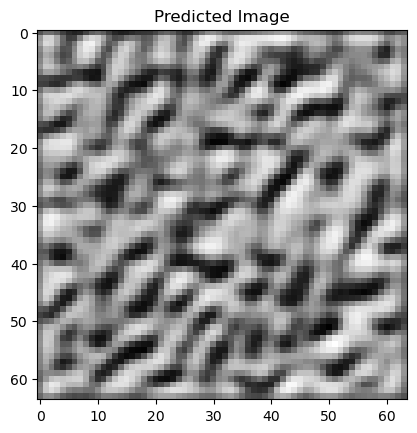

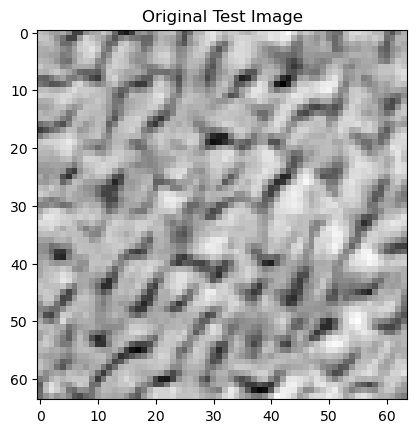

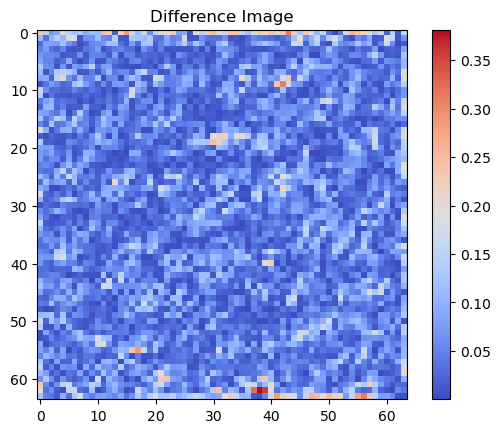

In [11]:
# Predict the images using the trained autoencoder
predicted_images = unet_autoencoder.predict(test_images)

# Display the first predicted image
plt.imshow(predicted_images[0].reshape(64, 64), cmap='gray')
plt.title('Predicted Image')
plt.show()

# Display the corresponding test image
plt.imshow(test_images[0].reshape(64, 64), cmap='gray')
plt.title('Original Test Image')
plt.show()

# make a difference plot
difference_image = np.abs(predicted_images[0].reshape(64, 64) - test_images[0].reshape(64, 64))
plt.imshow(difference_image, cmap='coolwarm')
plt.title('Difference Image')
plt.colorbar()
plt.show()



## Extract the latent space representation 

In [12]:
latent_features = encoder.predict(test_images)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


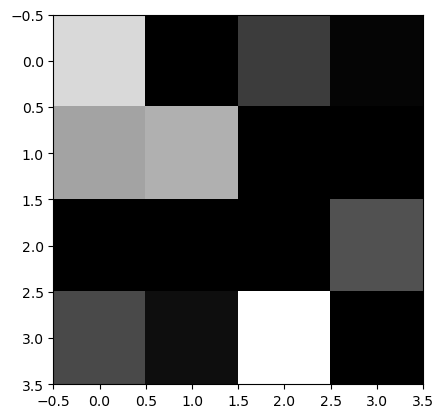

In [13]:
reshaped_latent_image = latent_features[10].reshape(4, 4)
plt.imshow(reshaped_latent_image, cmap= "gray")

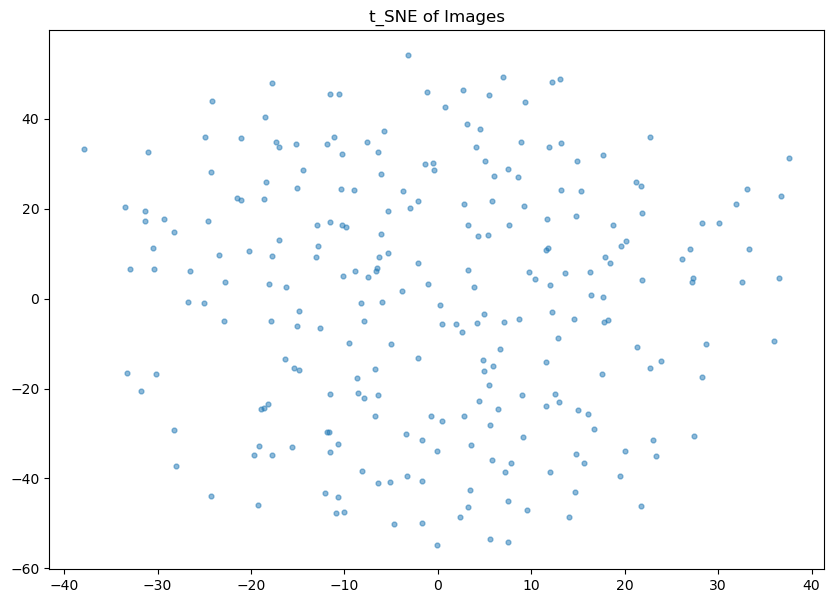

In [14]:
flatten_features = image_flattening(latent_features, target_size = (64, 64))
tsne_result = apply_tsne(flatten_features, n_components=3, perplexity=30)
plot_dim_reduction(tsne_result, title = "t_SNE")

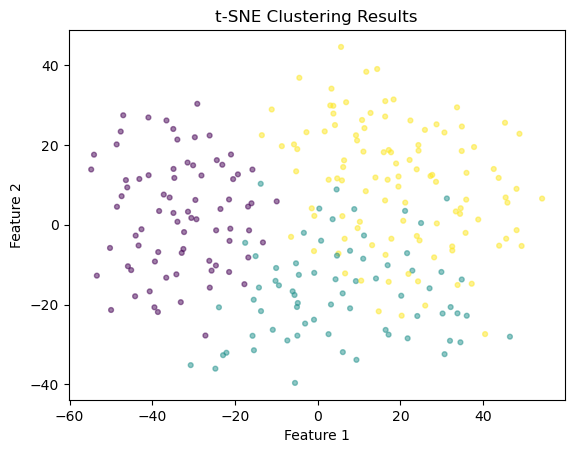

In [22]:
labels = apply_gmm(tsne_result, n_components=3)
plot_clustering_predictions(tsne_result[:,1:], labels, title = "t-SNE")

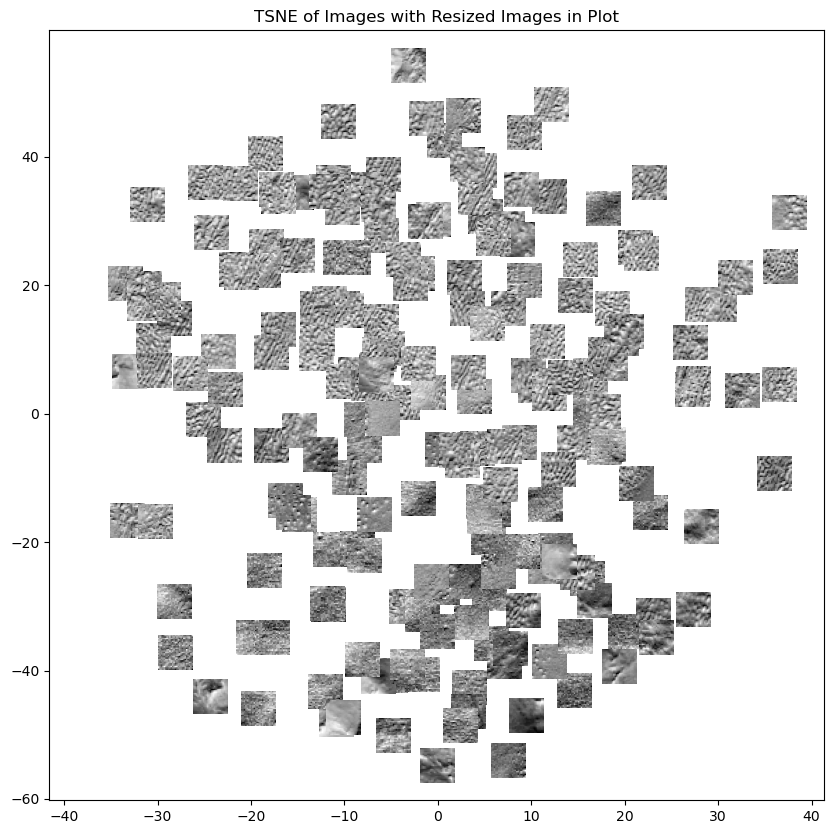

In [ ]:
selected_images, selected_results = random_select_images(test_images, tsne_result[:,1:], num_images=200)

plot_with_images(tsne_result, "TSNE", selected_images, selected_results, new_size=(25, 25))